### Load Data From Kaggle

In [ ]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 /content/drive/MyDrive/kaggle.json
! kaggle datasets download -d oddrationale/mnist-in-csv
! unzip mnist-in-csv.zip -d dataset_mnist

 66% 10.0M/15.2M [00:00<00:00, 41.0MB/s]
100% 15.2M/15.2M [00:00<00:00, 58.8MB/s]
Archive:  mnist-in-csv.zip
  inflating: dataset_mnist/mnist_test.csv  
  inflating: dataset_mnist/mnist_train.csv  


# Fully Connected Neural Network

In [ ]:
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

#### Preprocessing Data

In [ ]:
train_data = pd.read_csv("/content/dataset_mnist/mnist_train.csv")
test_data = pd.read_csv("/content/dataset_mnist/mnist_test.csv")


data = train_data
data = train_data.append(test_data, ignore_index = True)

In [ ]:
# Sampling Data
data = data.sample(frac=1)
y,x=data['label'].to_numpy(),data.drop(columns=['label']).to_numpy()

# One Hot Encoding
ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1,1)).toarray()

# Mean Substracting images
mean_image = np.mean(x,axis=0)

x = x-mean_image[:,np.newaxis].reshape(-1,28*28)

# Splitting data
# train_size = 55000, val_size = 5000
train_x,test_x,train_y,test_y = train_test_split(x,y,train_size=0.85715)
train_x,val_x,train_y,val_y = train_test_split(train_x,train_y,train_size=0.91668)

In [ ]:
train_x = train_x.reshape(-1,28*28)
# train_y = train_y.reshape(-1,1)
test_x = test_x.reshape(-1,28*28)
# test_y=test_y.reshape(-1,1)

In [ ]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(55000, 784)
(10000, 784)
(55000, 10)
(10000, 10)


#### Creating Network Class

In [ ]:
class Network():
  def __init__(self, number_of_layers, input_dim,neurons_per_layer,active_fun=1):
    self.n_layers = number_of_layers
    self.input_dim = input_dim
    self.n_neurons = neurons_per_layer
    if active_fun==1:
        self.af=self.sigmoid
        self.afd = self.sigmoid_derivative
    elif active_fun==2:
        self.af=self.tanh
        self.afd=self.tanh_derivative
    else:
        self.af=self.relu
        self.afd=self.relu_derivative
    # initialize weights
    self.weights = []
    self.weights.append(np.random.randn(self.input_dim+1,self.n_neurons[0]))
    for i in range(0,self.n_layers-2):
      self.weights.append(np.random.randn(self.n_neurons[i]+1,self.n_neurons[i+1]))
    
    self.activations = [[]]*int(self.n_layers-1) # activations[0] = layer 1 ...
    self.gradients = []
    self.zs = [[]]*int(self.n_layers-1)

  def relu(self, s):
      # activation function

    return np.where(s <= 0, 0, s)


  def relu_derivative(self, s):
      #derivative of relu
    return np.where(s <= 0, 0, 1)

  def sigmoid(self, x):
    return 1/(1+np.exp(-x))

  def softmax(self,z):
    return np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True)

  def softmax_derivative(self,x):
    # Reshape the 1-d softmax to 2-d so that np.dot will do the matrix multiplication
    return x*(1-x)

  def tanh(self, s):
        # activation function
    return np.tanh(s) # apply tanh function on s and return it's value

  def tanh_derivative(self, s):
      #derivative of tanh
    return 1-np.square(self.tanh(s))# apply derivative of tanh on s and return it's value
  
  def sigmoid_derivative(self,x):
    return self.sigmoid(x)*(1-self.sigmoid(x))

  def derivative_crossentropy_wrt_y(self,y,y_pred):
      return -1 * (np.divide(y, y_pred) - np.divide(1 - y, 1 - y_pred))

  def crossentropy(self, y, y_pred):
    # compute error based on crossentropy loss 
    error = np.mean(np.multiply(y,np.log(y_pred))+np.multiply((1-y),np.log(1-y_pred)),keepdims=True)
    return -1*error

  def crossentropy_(self, y, y_pred):
    # compute error based on crossentropy loss 
    error = np.mean(np.multiply(y,np.log(y_pred))+np.multiply((1-y),np.log(1-y_pred)))
    return -1*error


  def feedforward(self,x):
    self.zs[0] = np.dot(x,self.weights[0][:self.input_dim])+self.weights[0][-1]
    self.activations[0] = self.sigmoid(self.zs[0])
    # print(self.zs[0].shape)
    for nl in range(1,self.n_layers-1):
      self.zs[nl] = np.dot(self.activations[nl-1],self.weights[nl][:self.n_neurons[nl-1]])+self.weights[nl][-1]
      if nl==self.n_layers-1:
        af = self.stable_softmax
      else:
        af = self.af
      # print(af(self.zs[nl]).shape)
      self.activations[nl] = af(self.zs[nl])
      # print(self.activations[nl].shape)
    return self.activations[-1]

    # last layer softmax

  def update_weights(self,weight_grads,lr):
    
    for i in range(self.n_layers-1):
      self.weights[i] -= lr*(weight_grads[i])

  def accuracy(self,y,y_pred):
    y = np.argmax(y, axis=1)
    pred = np.argmax(y_pred, axis=1)
    return np.sum(pred == y) / len(y)

  def stable_softmax(self, x):
    z = x - max(x)
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    softmax = numerator/denominator

    return softmax

  def backward_propagation(self,x, y, y_pred, lr):

    weight_grads = [np.zeros(w.shape) for w in self.weights]

    # δ_output

    delta = self.derivative_crossentropy_wrt_y(y,y_pred)*self.softmax_derivative(y_pred)
    # print(weight_grads[-1][:self.n_neurons[-2]].shape)
    weight_grads[-1][:self.n_neurons[-2]] = np.dot(delta.T,self.activations[-2]).T
    weight_grads[-1][-1] = np.sum(delta,keepdims=True)

    for i in range(2,self.n_layers):
      delta = np.dot(self.weights[-i+1][:self.n_neurons[-i]],delta.T).T*self.afd(self.zs[-i])
      if i < self.n_layers-1:
        weight_grads[-i][:self.n_neurons[-i-1]] = np.dot(delta.T,self.activations[-i-1]).T
      else:
        weight_grads[-i][:self.input_dim] = np.dot(delta.T,x).T
      weight_grads[-i][-1] = np.sum(delta,axis=0,keepdims=True)

    return weight_grads


  def train(self, train_x, train_y,cost=None,epochs = 100, learning_rate = 0.001, plot_err = True ,val_x = None, val_y = None,acc=None):


    for i in range(epochs):

      y_pred = self.feedforward(train_x)
      grads = self.backward_propagation(train_x,train_y,y_pred,learning_rate)
      self.update_weights(grads,learning_rate)
      loss = self.crossentropy(train_y,y_pred)
      accuracy = self.accuracy(train_y,y_pred)
      print("epoch: %d, loss: %f, acc: %f"%(i, loss,accuracy))
      # pred_val = self.feedforward(val_x)
      cost.append(loss)
      acc.append(accuracy)

    return cost, acc



##### Training Model

In [ ]:
net = Network(4,28*28,[128,64,10],active_fun=1)
cost = []
acc = []
cost,acc = net.train(train_x,train_y,epochs=100,learning_rate=0.0001,val_x=val_x,val_y=val_y,cost=cost,acc=acc)

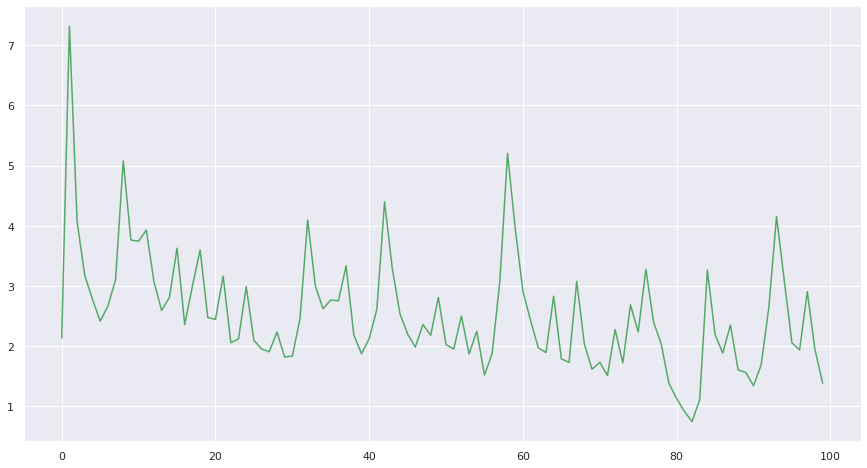

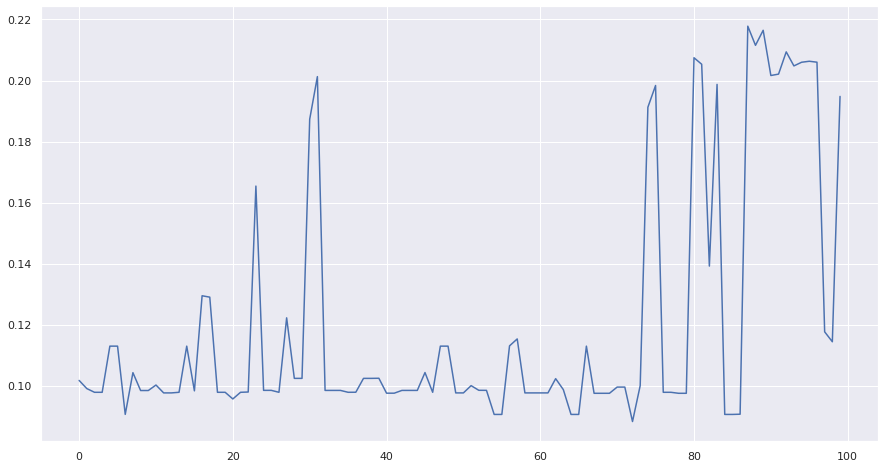

In [ ]:
cost_1d = [c[0][0] for c in cost]
plt.plot(np.array(cost_1d),'g')
plt.show()
plt.plot(np.array(acc),'b')
plt.show()

##### Accuracy and Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
rounded_labels=np.argmax(test_y, axis=1)

cm_test = confusion_matrix(rounded_labels,np.argmax(net.feedforward(test_x), axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


In [ ]:
rounded_labels=np.argmax(train_y, axis=1)

cm_train=confusion_matrix(rounded_labels,np.argmax(net.feedforward(train_x), axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


In [ ]:
rounded_labels=np.argmax(val_y, axis=1)

cm_val=confusion_matrix(rounded_labels,np.argmax(net.feedforward(val_x), axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


In [ ]:
test_accuracy = net.accuracy(test_y,net.feedforward(test_x))
train_accuracy = net.accuracy(train_y,net.feedforward(train_x))
val_accuracy = net.accuracy(val_y,net.feedforward(val_x))

print(test_accuracy)
print(train_accuracy)
print(val_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


0.1974
0.19014545454545453
0.1842


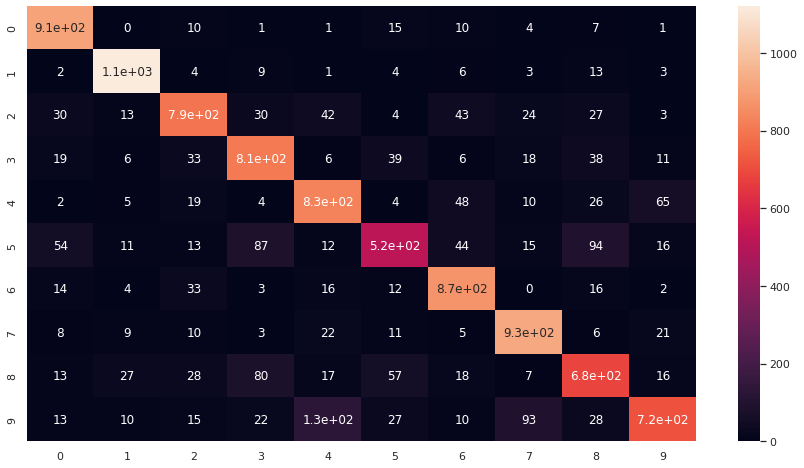

In [ ]:
import seaborn as snNew


DetaFrame_cm = pd.DataFrame(cm_test, range(10), range(10))
snNew.heatmap(DetaFrame_cm, annot=True)
snNew.set(rc = {'figure.figsize':(15,8)})

plt.show()

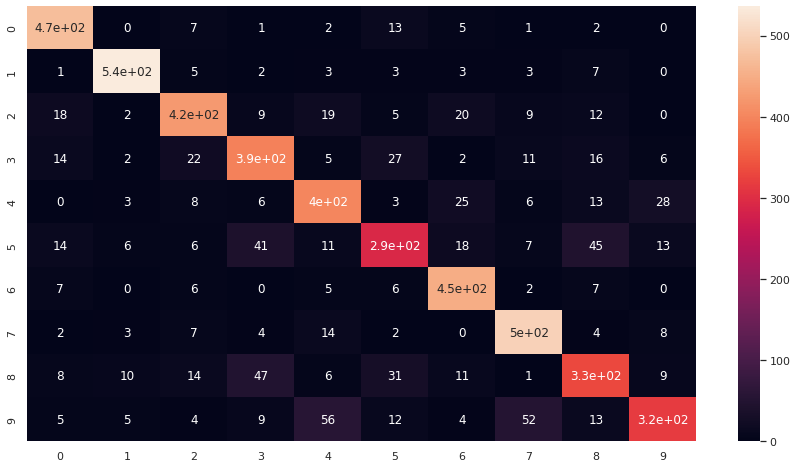

In [ ]:
DetaFrame_cm = pd.DataFrame(cm_val, range(10), range(10))
snNew.heatmap(DetaFrame_cm, annot=True)
snNew.set(rc = {'figure.figsize':(15,8)})

plt.show()

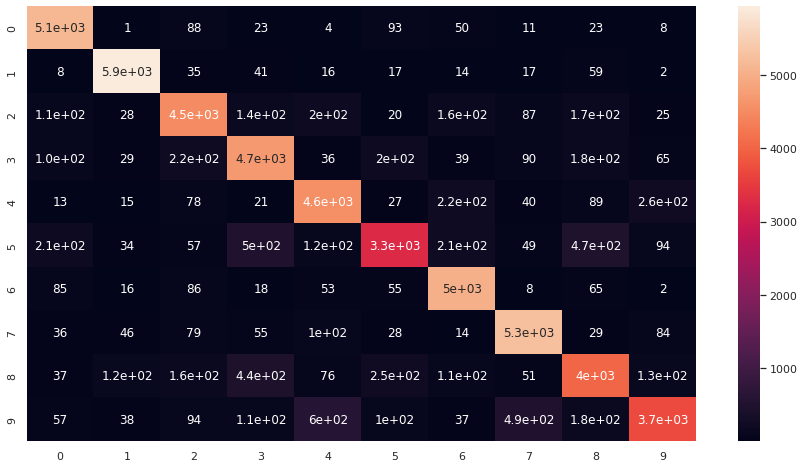

In [ ]:
DetaFrame_cm = pd.DataFrame(cm_train, range(10), range(10))
snNew.set(rc = {'figure.figsize':(15,8)})
snNew.heatmap(DetaFrame_cm, annot=True)
plt.show()

In [ ]:
print(test_accuracy)

0.8182
